<a href="https://colab.research.google.com/github/SLCFLAB/Data-Science-Python/blob/main/Day%2014/14_2_2_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 차트에 한글이 나오게끔 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,499 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: fall

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt

# plt.style.use('dark_background')

### ref: 본 ipynb 파일은 다음 웹사이트를 참고했습니다.
---

2021.11.09 조준우 (metamath@gmail.com), https://metamath1.github.io 

https://metamath1.github.io/2021/11/11/transformer.html

## 트랜스포머를 공부하는 이유

트랜스포머는 최근 가장 성공적인 모델임에도 불구하고 CNN, RNN에 대한 사전 지식이 전혀 필요없이 이해할 수 있다는 점에서 입문자분들이 꼭 공부하면 좋을 모델이라고 할 수 있습니다. 트랜스포머를 이해하기 위한 사전 지식은 다음 정도로 정리할 수 있습니다. 

- 신경망에서 완전 연결층 
- 소프트맥스 함수
- $\sin$, $\cos$ 함수 기초
- 데이터를 인코딩해서 다시 디코딩하는 개념
- 배치 정규화와 레이어 정규화의 차이
- 임베딩 개념
- 어텐션 개념

앞 네 개 항목은 인공지능에 막 입문한 학습자라도 어느정도 알고 있는 내용이므로 실제로 입문자가 느끼는 추가 학습 부담은 정규화와 임베딩 개념 그리고 가장 핵심인 어텐션이라고 할 수 있습니다. 임베딩에 대해서는 입력을  특정 길이를 가지는 벡터로 바꾼다는 정도만 알아도 전체 내용을 이해하는데 지장이 없습니다. 어텐션에 대해서는 이전 모델인 seq2seq와 그에 대한 어텐션 매커니즘을 알고 있다면 도움이 되지만 몰라도 상관없습니다. 

이렇게 트랜스포머는 완전 연결층에 대한 기본적인 지식만 가지고 바로 학습할 수 있다는 장점에 더불어 최신 모델들의 근간을 이루는 기본 모델을 공부할 수 있다는 추가 장점도 가지고 있습니다. 




## 트랜스포머 개요

![picture](https://drive.google.com/uc?id=1DudF_35VyVpevpsLr7TfVWi6WeC527kc)
Figure 1: The Transformer - model architecture.[[4](https://arxiv.org/abs/1706.03762)]

트랜스포머에 대한 그림 중 가장 유명한 그림이 바로 위 그림입니다. 이 그림은 처음 보면 아주 복잡하게 보이지만 트랜스포머를 이해하고 보면 간결하게 모델의 핵심을 잘 설명하고 있다는 것을 알게 됩니다. 이 그림을 통해서 먼저 트랜스포머에 대한 전체 맥락을 알아보겠습니다. 트랜스포머가 적용되는 상황은 기계번역, 즉 입력으로 영어 문장이 들어가서 출력으로 한국어 문장이 나오는 상황을 가정하겠습니다. 그러면 위 그림은 다음과 같은 순서로 데이터가 처리되는 것을 이야기하고 있습니다.

1. 입력(Input)이 임베딩 층으로 입력되어 문장의 각 단어들이 적당한 벡터로 변환된다.
2. 이 변환된 벡터가 위치 인코딩Positional Encoding이라는 것으로 부터 출력된 단어의 위치 정보를 가지는 벡터와 더해진다.
3. 2에서 만들어진 벡터가 멀티 헤드 어텐션Multi-Head Attention이라는 층으로 입력되는데 이 때 같은 입력을 키key, 쿼리query, 벨류value로 넣어준다. 
4. 멀티 헤드 어텐션 층을 거쳐 출력된 벡터가 멀티 헤드 어텐션 층으로 입력되기 전 벡터와 더해지고(ResNet의 스킵커넥션) 레이어 정규화 된다.
5. 4의 출력을 Linear 레이어에 입력하여 출력을 만든다. 
6. 5의 출력과 4의 출력을 더하고 레이어 정규화 한다. (또 한번 스킵커넥션)
7. 6에서 출력된 결과를 입력으로 3으로 돌아가 다시 반복한다. 이렇게 N번 반복한다.

여기까지가 트랜스포머의 인코더에 해당되는 내용입니다. 다음은 디코더에 대한 내용입니다.

1. 입력과 쌍이 되는 정답을 디코더에 입력한다.
2. 인코더와 마찬가지로 정답에 대해서 인코더의 1, 2 과정을 거친다.
3. 이렇게 만들어진 벡터를 인코더의 3번, 4번 과정과 동일하게 어텐션한다. 단, 이때 마스크를 씌우게 되는데 이 마스크를 씌우는 부분이 트랜스포머를 이해하는 난관 중 하나입니다. 구체적인 세부 사항은 코드와 함께 설명하겠습니다. 여기서는 일단 어텐션 한다고 생각하면 되겠습니다.
4. 3의 출력으로 다시 한번 어텐션하는데 이때는 키, 벨류는 인코더의 출력으로 설정하고 쿼리를 앞 3번 과정의 출력으로 설정하여 어텐션 한다. 
5. 4의 출력을 입력으로 Linear 레이어를 통과하고 스킵커넥션, 레이어 정규화를 적용한다.
6. 5의 출력을 입력으로 3으로 돌아가 다시 반복한다. 이렇게 N번 반복한다.

마지막으로 디코더의 내용으로 부터 클래스의 확률을 계산하는 부분은

1. 디코더에서 6의 출력을 Linear층으로 입력한다.
2. 1의 출력을 Softmax층으로 입력하여 클래스에 대한 확률을 계산한다.

이고, 이것이 트랜스포머의 가장 핵심적인 내용입니다. 알고 보면 별것 아닌 내용인데 처음 공부하려면 꽤 복잡해 보이기도 한 것이 사실입니다. 

여기서 주의해야할 점은 트랜스포머에 입력은 타임스탭별로 하니씩 입력되지 않고 모든 타임스탭의 입력이 동시에 입력되고 출력도 마찬가지라는 점입니다. 예를 들어 다음과 같은 입력이 있을 때

`<start>` `I` `don't` `know` `what` `you` `mean` `<end>`

입력의 일곱개 단어가 모두 한번에 입력되고 여기에 대한 정답이 다음과 같을 때 

`<start>` `나는` `니가` `의미하는` `바를` `모르겠다` `<end>`

디코더의 입력으로는

`<start>` `나는` `니가` `의미하는` `바를` `모르겠다`

이 들어가고 출력으로는 

`나는` `니가` `의미하는` `바를` `모르겠다` `<end>`

가 나오기를 기대하는 것입니다. 물론 RNN을 사용한 seq2seq같은 모델을 아예 모르는 초심자라면 이런 내용에 주의를 할 필요 조차 없습니다. 그냥 입력이 문장 통째로 들어가서 출력이 문장 통째로 나온다고 생각하면 됩니다.

이제 코드를 보면서 그림의 순서대로 따라가봅시다.

## Embedding

트랜스포머에 입력 데이터인 단어를 입력하기 위해서는 단어에 대해 두가지 전처리를 거쳐야 하는데 하나는 임베딩이고 다른 하나는 위치 인코딩입니다. 모델에 단어를 입력할 때 단어를 숫자로 바꿔서 입력하게 되는데 이 때 가급적 목적하는 작업에 도움이 되도록 바꿔야 할 것입니다. 단어-숫자 변환을 최종 작업에 도움이 되는 방향으로 하기 위해 임베딩embedding이라는 층을 사용하게 됩니다. 임베딩 층은 단어를 입력받아 적절한 숫자 벡터로 변환하는 층으로 변환되어 출력되는 벡터의 길이를 코드에서 `d_model`로 표시합니다.

임베딩층이 하는 일은 원핫인코딩된 입력벡터를 적절한 밀집벡터로 바꿔주는 것으로 다음처럼 작동합니다.<sup>&#8224;</sup> 

$$
\mathbf{x}_{\text{emb}}=\mathbf{x}W_{\text{emb}}
$$

여기서 임베딩 층이 가지는 가중치 행렬 $W_{\text{emb}}$의 크기는 $(\text{vocab}, d_{\text{model}})$이 되고 입력 벡터 $\mathbf{x}$는 길이가 $(1, \text{vocab})$인 원핫인코딩된 벡터입니다. 따라서 임베딩 층의 가중치 행렬은 특정 단어에 해당하는 $d_{\text{model}}$차원의 벡터를 행으로 가지고 있는 룩업 테이블이라고 할 수 있습니다. 다음 그림처럼 단어장에서 단어의 순번을 가지고 변환될 벡터를 찾는 것입니다.

그림을 보면 제일 먼저 'prime'이란 단어를 단어장에서 몇번째 단어인지 찾습니다. 그렇게 찾은 단어의 순번 자리만 1이 되고 나머지는 다 0인 전체 단어 개수만큼 요소를 가지는 원핫벡터를 만듭니다. 이 원핫벡터를 $W_{\text{emb}}$에 행렬곱해서 임베딩 벡터를 얻는 것입니다.<sup>&#8224;&#8224;</sup>  이렇게 임베딩 층을 거치면 입력이 길이 $d_{\text{model}}$인 벡터로 변환됩니다.


In [7]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        # 임베딩 벡터에 sqrt(d_model)을 곱해서 임베딩 벡터의 요소들 값을 
        # 증가 시킴.
        # d_model은 512정도 되는 큰 값이이므로 22정도 되는 값이 
        # 임베딩 벡터 요소에 곱해짐. 
        # 곱하는 이유는 뒤에 포지션 벡터를 더할텐데 이 때 포지션 벡터에
        # 의해 임베딩 결과가 희석되는 것을 막기 위함
        # ref.: https://stackoverflow.com/questions/56930821/why-does-embedding-vector-multiplied-by-a-constant-in-transformer-model
        return self.lut(x) * math.sqrt(self.d_model)

코드는 파이토치 `nn.Embedding`을 그대로 사용합니다. 단 위 코드에서 임베딩 층을 포워드 시킨 결과에 $\sqrt{d_{\text{model}}}$을 곱하고 있는 점이 좀 특이합니다. 이렇게 상수를 곱하는 이유는 뒤에 설명할 포지션 벡터가 임베딩 벡터에 더해지는데 이 때 포지션 벡터가 더해지면서 임베딩 벡터의 값이 희석되는 것을 막기 위해 임베딩 벡터의 요소 크기를 상대적으로 크게 하기 위함일 것으로 생각됩니다.[[5](https://stackoverflow.com/questions/56930821/why-does-embedding-vector-multiplied-by-a-constant-in-transformer-model)] 이런 해석은 논문에서 공식적으로 밝히고 있는 것은 아닙니다. 논문에서는 그냥 $\sqrt{d_{\text{model}}}$를 곱한다고만 되어 있습니다.

이 과정을 거쳐서 길이 $n_{\text{seq}}$인 입력 문장의 각 단어를 임베딩 벡터로 모두 변환하게 되면 $(n_{\text{seq}}, d_{\text{model}})$인 행렬로 변환되게 됩니다.

## Positional Encoding

앞서 이야기한 위치 인코딩입니다. 트랜스포머는 RNN같은 순차적 구조를 사용하지 않고 문장 전체를 한꺼번에 입력하여 문장에 있는 단어간 관계를 특징화하는 모델입니다. RNN은 토큰이 순차적으로 입력되므로 토큰 순서 정보가 자연스럽게 생겨나는 반면 트랜스포머는 토큰의 순서 정보를 인위적으로 만들어 넣어줄 필요가 있습니다. 순서 정보를 인위적으로 만들기위해 논문 저자들은 위치 인코딩이라는 방법을 사용합니다. 

$$
PE_{(pos,2i)}=\sin \left( \frac{pos}{10000^{2i/d_{\text{model}}}} \right)
$$

$$
PE_{(pos,2i+1)}=\cos \left( \frac{pos}{10000^{2i/d_{\text{model}}}} \right)
$$

위 식을 사용하여 입력 문장의 위치 정보를 $(n_{\text{seq}}, d_{\text{model}})$인 행렬로 인코딩 합니다. 식을 보면 행은 단어의 위치를 나타내는데 단어 위치별 값은 $pos$ 변수에 의해 달라집니다. 열에 대해서는 홀수 열은 $\cos$함수로 짝수 열은 $\sin$함수를 사용해서 값을 다르게 계산하는데 열 인덱스 $i$에 대해서 각각 다른 주기(첫 두 열부터 $2 \pi$ 주기에서 시작해서 마지막 두 열에서는 거의 $10000 \times 2 \pi$ 주기를 가짐) 의 삼각함수를 사용하여 모든 열에 대해서 다른 값을 계산하게 됩니다.

문장 길이 120에 `d_model=512`인 경우 위치 인코딩을 직접 해보면 다음과 같습니다.


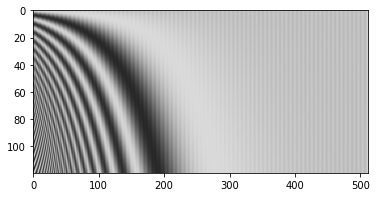

In [8]:
seq_length = 120
d_model = 512

PE = np.zeros((seq_length, d_model))

for pos in range(seq_length):
    for i in range(d_model//2):
        PE[pos, 2*i]   = np.sin( pos / (10000**(2*i/d_model)) )
        PE[pos, 2*i+1] = np.cos( pos / (10000**(2*i/d_model)) )

plt.figure(figsize=(6,3))
plt.imshow(PE, aspect='auto', cmap='gray', interpolation='gaussian')
plt.show()


그림으로 표시된 행렬의 각 행은 단어의 위치별로 다르게 계산된 숫자 512개로 구성되어 있고 이 행 벡터가 단어의 위치 정보를 나타내는 고유한 값이 되는 것입니다.


In [9]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        pe_val = self.pe[:, :x.size(1)]
        pe_val.requires_grad = False
        
        x = x + pe_val
        # x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)

        # page 7
        # In addition, we apply dropout to the sums of the embeddings and the
        # positional encodings in both the encoder and decoder stacks.
        # For the base model, we use a rate of Pdrop=0.1.
        return self.dropout(x)
        
        

그리고 마지막 출력을 `nn.Dropout`을 통과시켜 규제regularization 효과를 주고 있습니다.

## Encoder

이제 인코더로 데이터를 입력하기 위한 준비를 마쳤으니 인코더 구조를 알아봅시다. 글 시작 부분에 제시된 트랜스포머의 그림에서 Multi-Head Attention, Add & Norm 부분을 조금 더 자세히 그리면 아래와 같습니다.

![picture](https://drive.google.com/uc?id=10OW0QpQ5jTiW_K__FjmNZphB3fKuSacy)



임베딩과 포지션 인코딩이 끝난 입력이 Q, K, V라는 세 입력으로 인코더로 들어갑니다. 일반적으로 Q(쿼리), K(키), V(벨류)는 다른 값이 되어야 하지만 여기선 셀프 어텐션을 수행하기 때문에 같은 값으로 입력됩니다. 어텐션은 트랜스포머 이전까지 인코더와 디코더 간에 일어나는 연산으로 개발되었으며 셀프 어텐션에 대응되는 용어로 크로스 어텐션이라고 부르기도 합니다. 


### Attention


어텐션의 기본적인 동작 방식은 쿼리를 가지고 키로 질의를 해서 얻은 어텐션 가중치를 벨류에 적용하는 것입니다. 보통 어텐션에서 키란 인코더에서 생성한 정보로 이 정보를 디코더에게 효율적으로 전달하는 것이 어텐션의 주 목적입니다. 왜냐하면 디코더는 좋은 결과를 생성하기 위해 인코더의 정보를 가능한 많이 활용하는 편이 도움이 되기 때문입니다. 이전 seq2seq는 인코더가 인코딩한 마지막 결과만 디코더로 전달하기 때문에 디코더 입장에서는 좋은 결과를 생성하기 힘든 것이죠. 전체적인 과정은 대략 다음처럼 진행됩니다.

1. 인코더는 인코딩 중에 생성된 정보 다시말해 키를 모두 가지고 있습니다.
2. 디코더가 정보를 생성할 때 디코더가 만든 중간 결과 즉 쿼리를 가지고 이 쿼리와 가장 관계가 높은 정보가 어떤 것인지 인코더 쪽에 물어 봅니다. 
3. 인코더는 자기가 인코딩하면서 생성한 정보(키)들 중에 요청받은 쿼리와 어떤 키가 얼마나 적합한지 가중치 계산을 합니다.
4. 인코더는 이렇게 계산된 가중치를 디코더로 전달할 벨류라는 값에 가중합하여 디코더로 전달합니다.
5. 디코더는 4에서 전달받은 정보와 현재 디코더가 디코딩한 정보를 합하여 최종 결과를 만들어 냅니다.

이렇게 크로스 어텐션인 경우 대충 아이디어만 들어도 충분히 성능 향상에 영향을 미치겠다는 생각이 듭니다. 하지만 트랜스포머는 이 어텐션 아이디어를 인코더 또는 디코더에만 적용하는 식으로 적용범위를 넓혔습니다. 인코더는 입력 정보끼리 어텐션을 계산해서 디코더가 디코딩하기 좋은 인코딩 정보를 만들어 낼 수 있고 디코더도 마찬가지로 디코딩되는 정보 끼리 어텐션을 해서 더 좋은 결과를 만들어 낼수 있게 되는 것입니다. 이런 어텐션을 셀프 어텐션이라 합니다.

셀프 어텐션은 논문에서 제시하는 다음 수식으로 수행됩니다.

$$
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right)V
$$






이렇게 셀프 어텐션이 되면 어떤 점이 좋아지는지 개념을 이해하기 위해 간단한 그림을 보도록 하겠습니다.


![picture](https://drive.google.com/uc?id=1c_TAUg5FY3YNknOMKZMW8XGGbwTNGlzF)

위 그림은 i love you so much라는 토큰들이 임베딩되는 상황을 나타냅니다. 우선 $W^Q_i$, $W^K_i$, $W^V_i$를 각각 곱하여 $Q$, $K$, $V$를 만들고 그렇게 만들어진 텐서는 색깔을 다르게 표현했습니다. 이후 $\text{softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right)$가 실행되면 $(n_{\text{seq}}, n_{\text{seq}})$인 `p_attn` 행렬이 만들어지는데 이 행렬은 각 토큰들간의 관계가 계산되도록  $W^Q_i$, $W^K_i$가 학습되길 바라는 것입니다.  $W^Q_i$, $W^K_i$가 잘 학습되어 i love you so much라는 문장에서 각 토큰간의 관계가 잘 만들어졌다고 가정하겠습니다. 그러면 love라는 토큰은 한 문장안에서 love, you 라는 토큰하고 관계가 높게 표현될 수 있습니다. 그림에서  `p_attn`을 보면 love에 해당하는 행에서 love와 you에 해당하는 열이 붉게 빛나는 것을 볼 수 있습니다. 이렇게 인코딩된 어텐션 행렬과 $V$를 곱하게 됩니다. 행렬곱은 앞에서 곱하는 행렬의 행으로 뒤에서 곱하는 행렬의 행을 선형조합하는 것과 같습니다. 최종적으로 계산된 `head_i`에서 love에 해당하는 행은 $V$ 행렬의 행 다섯 개가 선형조합된 것인데 이때 $V$에서 love와 you에 해당하는 행에 높은 가중치가 부여되어 조합된 벡터가 됩니다. 

이렇게 셀프 어텐션되어 출력되는 결과는 각 토큰이 `d_model`사이즈로 변환된 벡터를 가지는데 그치지 않고 각 벡터들이 서로 관계가 높은 토큰들끼리 잘 조합되어 만들어진 벡터가 되게 됩니다.

아래 코드는 어텐션을 구현한 것입니다. 쿼리, 키, 벨류로 무엇을 입력는가에 따라 셀프 어텐션과 크로스 어텐션으로 나눌 수 있으므로 구현 코드는 두 경우 모두 동일합니다.


In [10]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    # 아래서 nbatches는 미니배치 크기, 코드에서 nbatches라는 변수명을 쓰므로
    # 표기를 통일하기 위해 nbatches로 표기
    # query: (nbatches, h, n_seq, d_k)
    # key:   (nbatches, h, n_seq, d_k)
    # value: (nbatches, h, n_seq, d_v) 인데 d_k=d_v로 두었음
    # 이 함수는 아래쪽 MultiHeadedAttention 클래스의 foward 함수에서 호출됨

    d_k = query.size(-1)
    
    # Scaled에 대한 여러 참고 링크들
    # https://stats.stackexchange.com/questions/318243/variance-and-expectation-of-dot-product
    # https://www.reddit.com/r/learnmath/comments/9gbk4q/mean_and_variance_of_dot_product_of_two_random/
    # https://stats.stackexchange.com/questions/52646/variance-of-product-of-multiple-random-variables
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    # scores: (nbatches, h, n_seq, n_seq)
    
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    p_attn = F.softmax(scores, dim = -1)

    if dropout is not None:
        p_attn = dropout(p_attn)

    # torch.matmul(p_attn, value): (nbatches, h, n_seq, n_seq)*(nbatches, h, n_seq, d_v)
    # = (nbatches, h, n_seq, d_v),      p_attn: (nbatches, h, n_seq, nseq)
    return torch.matmul(p_attn, value), p_attn

#### Multi-Head Attention

앞 절에서 이야기한 어텐션을 한번만 하는 것이 아니라 $h$번하고 그 결과로 나온 $(n_{seq}, d_{v})$인 결과 $h$개를 $d_v$ 방향으로 `concat`시켜 최종적으로 $(n_{seq}, hd_{v})$ 만들게 됩니다. 위 인코더 그림에서 이를 표현하고 있습니다. 

그리고 이 $(n_{seq}, hd_{v})$를 $(hd_{v}, d_{model})$인 $W^o$와 곱하여 결과를 $(n_{seq}, d_{model})$로 만들게 됩니다. 아래 그 코드가 있는데 매우 교묘하게 코딩되어 있어 주의깊게 볼 필요가 있습니다. 우선 코드에 적혀있는 주석을 읽고 코드를 이해해봅시다.


In [11]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [12]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h  # Q, K의 차원
        self.h = h
        
        # Wq, Wk, Wv and Wo
        # Wq, Wk, Wv를 각각 h개 만들지 않고 
        # Wq, Wk, Wv를 d_model의 1/h 크기로 만듬
        self.linears = clones(nn.Linear(d_model, d_model), 4) 
        
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        # query, key, value: (n_seq, d_model)
        "Implements Figure 2"
        if mask is not None:
            # EncoderLayer에서 호출될 때
            # mask는 src_mask: (nbatches, 1, n_seq_src)
            # DecoderLayer에서 호출될 때
            # self_attn으로 호출되면 mask는 tgt_mask: (nbatches, n_seq_trg, n_seq_trg)
            # src_attn(cross_attn)으로 호출되며 mask는 src_mask: (nbatches, 1, n_seq_src)
            
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        # self.linears는 요소 네갠데 (query, key, value)와 짝을 맞춰서
        # 루프는 총 3번 돌아감
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        # 이 라인이 실행되면 query, key, value는 각각
        # (nbatches, h, n_seq, d_k) 가 됨
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        # x: (nbatches, h, n_seq, d_v),  self.attn: (nbatches, h, n_seq, n_seq)

        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        # x: (nbatches, n_seq, h*d_k) 여기서 h*d_k=d_model

        # 4) matmul x and Wo -> (nbatches, n_seq, d_model)
        return self.linears[-1](x)

위 코드에서 가장 난해한 코드는 주석 1) 부분입니다. 

```python
# 1) Do all the linear projections in batch from d_model => h x d_k 
# self.linears는 요소 네갠데 (query, key, value)와 짝을 맞춰서
# 루프는 총 3번 돌아감
query, key, value = \
    [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        for l, x in zip(self.linears, (query, key, value))]
# 이 라인이 실행되면 query, key, value는 각각
# (nbatches, h, n_seq, d_k) 가 됨
```

1)에서 $(n_{seq}, d_{k})$ 모양의 쿼리, 키, 벨류 $h$개를 동시에 만들고 있습니다. 쿼리를 만드는 과정을 아래 그림으로 자세히 나타냈습니다. 나머지 키와 벨류에 대해서도 동일한 연산이 수행됩니다.
  
![picture](https://drive.google.com/uc?id=10JMUOLLUgyPJwqQvVyWG2J9MmUIB_gEo)

그림 상단에 코드가 주석 1)에 해당하는 코드이며 코드 부분이 진행되는 순서대로 텐서를 표현하였습니다. 1)에서 결과를 앞서 알아본 `attention` 함수로 입력하여 어텐션 결과와 어텐션 맵을 돌려 받는 부분이 2)입니다. 그런 다음 3)에서 $h$개 어텐션 결과를 `concat`하고 이를 4)에서 $W^O$와 곱하게 됩니다.

마지막 완전연결층의 가중치 $W^{O}$는 $(hd_v , d_{\text{model}})$ 크기를 가지므로 이 층의 입력차원은 $hd_v$, 출력차원은 $d_{\text{model}}$이 됩니다. 입력으로 들어오는 멀티 헤드 어텐션의 출력은 $(n_{\text{seq}} , hd_k)$입니다. 셀프 어텐션에서 $d_k=d_v$이므로 마지막 완전연결층을 통과하면 출력은 $(n_{\text{seq}},d_{\text{model}})$이 됩니다. 

위 멀티헤드어텐션 `forward()`에서 마지막 줄입니다.

```python
# matmul x and Wo -> (nbatches, n_seq, d_model)
return self.linears[-1](x)
```

3)과 4) 과정을 아래 그림으로 나타내었습니다. 인코더의 전체 그림과 함께 비교하면 이해하기가 훨씬 쉬워집니다.

![picture](https://drive.google.com/uc?id=10KXLvpL_UU1NbWQT5sTlaiF5EHtQdhek)


### EncoderLayer와 Encoder

인코더는 다음 그림처럼 `SublayeConnection`, `EncoderLayer`, `Encoder`로 구성됩니다. 트랜스포머는 인코더와 디코더가 각각 N번 반복됩니다. 여기서 N번 반복되는 단위를 `EncoderLayer`로 구현하였고 이를 N번 복사하여 가지고 있는 클래스가 `Encoder`가 됩니다. `EncoderLayer`내부에는 `SublayerConnection`이 있게 됩니다. 각 클래스가 좀 복잡할 정도로 조각조각 나있다는 느낌이 드는데 전체적인 구조는 다음 그림과 같습니다.

![picture](https://drive.google.com/uc?id=1a_MqSdbp9Ngjhkl6cNAUICb5tuDfBVjk)


그림은 보면 인코더는 `SublayerConnection`을 두 개, 디코더는 세 개 가지는 것을 알 수 있습니다.

 먼저 가장 기본 단위인 `SublayerConnection`부터 알아봅니다.


In [5]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)

        # torch.nn.LayerNorm()과 맞추기 위해 unbiased=False로 수정
        std = x.std(-1, unbiased=False, keepdim=True)
        # std = x.std(-1, keepdim=True)
        
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    

In [22]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."

        # (어텐션 or ff)-[드랍아웃]-Add and Norm으로 바꿨음
        # 드랍아웃은 논문에 sublayer에 썼다고 나와 있음
        # page 7        
        # We apply dropout [33] to the output of each sub-layer, 
        # before it is added to the sub-layer input and normalized. 
        # 층구성이 바뀌어서 아래쪽 hyperparam. warmup을 좀 키워야 됨
        # return x + self.dropout(sublayer(self.norm(x)))
        return self.norm(x + self.dropout(sublayer(x)))

`SublayerConnection`은 내부적으로 `LayerNorm`과 `Dropout`만 가지고 있습니다. 포워들 할 때 외부에서 `sublayer`를 넘겨받아 이 `sublayer`를 포워드 시키고 내부에 있는 드롭아웃과 정규화를 적용하는 식으로 동작합니다. 

그래서 `sublayer`가 어텐션 레이어이면 위 그림 아래쪽 회식 박스에 해당하고 피드 포워드 레이어이면 윗쪽 회색 박스에 해당하게 되겠습니다.

`EncoderLayer`는 `SublayerConnection`을 두 개 가지고 있습니다. 그리고 이 위 그림에서 확인할 수 있듯이 `SublayerConnection` 두 개는 각각 (어텐션 레이어, Add & Norm)과 (피드포워드 레이어, Add & Norm)으로 구성됩니다.

In [23]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        
        # self_attn: MultiHeadedAttention
        self.self_attn = self_attn

        # feed_forward: PositionwiseFeedForward
        self.feed_forward = feed_forward 
        
        # SublayerConnection이 2개
        self.sublayer = clones(SublayerConnection(size, dropout), 2) 
        self.size = size # d_model

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        # 1. 어텐션으로 람다 함수를 만들어서 sublayer[0]에 x와 함께 전달
        #    이때 어텐션 
        # 2. sublayer[0]가 포워드 되면서
        # 3. 레이어노멀 하고
        # 4. 인자로 넘긴 람다 함수가 sublayer로 돌면서 어텐션하고
        # 5. 드랍아웃하고 
        # 6. x와 더해져서 리턴 
        # 그냥 self_atten을 바로 넘기지 않는 이유는 self_attn에 x, mask를 같이 받기 때문에
        # x만 인자로 만들려고
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # 원래 코드는 이 시점에서 
        # x는 레이어놈-어텐션-드랍아웃-스킵커넥션 까지 됨
        # 하지만 위 SublayerConnection.forward에서 순서를 원래 논문 순서로 맞춰서
        # 어테션-드랍아웃-스킵커넥션-레이어놈 이 되었음
        
        # 7. 위와 마찬가지로 
        # 원 코드 순서는 레이어놈-ff-드랍아웃-스킵커넥션
        # 코드를 고쳐서 여기서도 
        # ff-드랍아웃-스킵커넥션-레이어놈
        return self.sublayer[1](x, self.feed_forward)

`EncoderLayer`는 내부적으로 `MultiHeadedAttention`과 `PositionwiseFeedForward`을 가지고 있습니다. 그리고 `SublayerConnection`을 두개 가지고 이 `SublayerConnection` 포워드 시킬 때 `layer`인자로 `MultiHeadedAttention`과 `PositionwiseFeedForward`을 각각 전달하게 됩니다. 그림을 보면 그림과 동일하게 구현되어 있음을 알 수 있습니다.

이제 마지막으로 `Encoder`입니다. `Encoder`는 생성자로 넘어오는 `EncoderLayer`를 N개 복사하고 포워드시 각각을 포워드 시키는 간단한 구조로 작성되었습니다.

In [24]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        
        # make_model()함수에서 아래처럼 생성될 예정
        # Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N)
        # 여기 layer는 EncoderLayer
        self.layers = clones(layer, N) 
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        # self.layers에는 EncoderLayer 여섯 개가 순차적으로 있음
        # 이 함수는 다음처럼 호출됨
        # EncoderDecoder.encode(
        #     self.encoder(self.src_embed(src), src_mask)
        # )
        # src_mask: (nbatches, 1, n_seq_src)
        
        for layer in self.layers: 
            # 여기 layer는 EncoderLayer고 EncoderLayer를 포워드 시킨다.
            # EncoderLayer포워드는 위 EncoderLayer 주석참고
            x = layer(x, mask) 
        
        # 논문 그림 구조와 맞추기 위해 SublayerConnection에서 norm하고
        # 여기선 안하는 것으로 바꿈
        # return self.norm(x)
        return x

### Positionwise Feed Forward

In [25]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

인코더에서 $(n_{\text{seq}}, d_{\text{model}})$ 크기를 가지는 텐서를 두번 Linear 층에 통과 시키게 되는데 이를 positionwise feed forward라고 이야기했습니다. 위 구조 그림에서 하늘색으로 표시된 부분입니다. 코드를 보면 가중치 행렬을 두번 곱하게 되는데 각 곱에 대해서 크기는 다음처럼 변하게 됩니다.

$(n_{\text{seq}}, d_{\text{model}}) \to (n_{\text{seq}}, d_{\text{ff}}) \to (n_{\text{seq}}, d_{\text{model}})$

이 변환은 $n_{\text{seq}}$의 각 자리에 해당하는 토큰 표현 벡터를 $d_{\text{model}}$에서 $d_{\text{ff}}$로 변환했다 다시 $d_{\text{model}}$차원으로 되돌리는 것입니다. positionwise라고 이름지은 이유는 각 토큰 표현에 해당하는 n_seq개 벡터가 각각 $d_{\text{ff}}$로 변환되었다 다시 $d_{\text{model}}$ 크기로 돌아오기 때문입니다.

이렇게 인코더에 대해서 모두 알아봤습니다. 인코더를 잘 이해하면 디코더를 80% 이상 이해한것입니다. 디코더에서는 추가로 고려해야할 사항을 중심으로 이야기 하도록 하겠습니다.

## Decoder

### 디코더에 적용되는 마스크

디코더에도 셀프 어텐션이 적용되는데 이 때는 이미 생성된 토큰 끼리만 어텐션 해야 합니다. 아직 생기지도 않은<sup>&#8224;</sup> 토큰과 어텐션할 수 없기 때문입니다.  seq2seq 모델처럼 시간순으로 타겟 토큰을 입력한다면 이는 자연스럽게 해결되지만 트랜스포머는 학습시 디코더에 모든 정답 토큰이 입력되므로 아직 어텐션 하지 않아아 될 부분을 지워내야 합니다. 그렇게 하기 위해 디코더에 입력되는 정답 시퀀스 길이를 행과 열로 가지는 마스크 행렬을 만드는데 이 행렬은 하삼각 요소와 주대각선만 1이고 상삼각행렬은 0을 가지게 됩니다. 


---
<sup>&#8224;</sup> "아직 생기지도 않은" 이란 표현에서 뭔가 혼란스러움을 느꼈다면 충분히 그럴 수 있습니다. 트랜스포머에는 모든 정답 토큰이 디코더로 한꺼번에 입력된다고 했는데 마치 시간 순으로 토큰이 디코딩 되는 듯한 "아직 생기지도 않은"이란 표현은 뭔가 어색하기 짝이 없습니다. 이런 이유 때문에 디코더쪽 마스킹을 이해하기 힘들어지는데 어떻게 표현하면 더 자연스러울지 잘 떠오르지 않아서 계속 고민중에 있습니다.

In [26]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

위 코드는 행과 열 수가 입력 토큰 수이고 상삼각 행렬이 모두 0인 행렬을 만드는 코드입니다.

torch.Size([1, 20, 20])


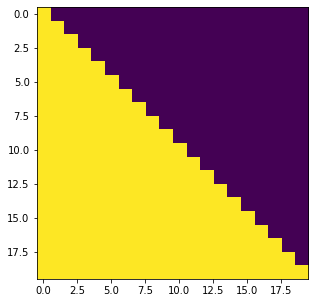

In [27]:
plt.figure(figsize=(5,5))

sub_mask = subsequent_mask(20)
print(sub_mask.shape)
plt.imshow(sub_mask[0])

이 마스크가 어떻게 적용되는지는 뒤에 상세히 예를 들어 설명하도록 하겠습니다.

### DecoderLayer와 Decoder

`DecoderLayer`와 `Decoder`의 구성은 인코더와 동일합니다. 한가지 다른 점은 `DecoderLayer`에는 어텐션이 두 개 있다는 점입니다. `forward()`함수를 보면 알 수 있듯이 셀프 어텐션과 인코더, 디코더 간의 크로스 어텐션입니다. 


In [28]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        # self_attn: MultiHeadedAttention
        # src_attn: MultiHeadedAttention

        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn # cross attention
        self.feed_forward = feed_forward # positional ff
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        # 여기서 momory는 인코더로 부터 넘어온 인코딩 (nbatche, n_seq, d_model)
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        
        # 크로스 어텐션 할 때 마스크는 src_mask(key_pad_mask)를 전달함!
        # 이렇게 하면 입력에 존재하는 패딩 토큰이 쿼리로써 인코딩되어 온 것을 
        # key 패딩으로 마스킹 할 수 있게 된다.
        # (인코더 출력이 이제는 key로 작용하기 때문에!!!)
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        
        return self.sublayer[2](x, self.feed_forward)

크로스 어텐션를 실행하는 코드를 보면 

```python
# x: 디코더에서 만든 (n_seq, d_mode) 텐서 (여기서 n_seq는 디코더로 입력되는 시퀀스의 길이)
# m: 인코더에서 전달받은 (n_seq, d_model) 텐서 (여기서 n_seq는 인코더로 입력된 시퀀스의 길이)
x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
```

셀프 어텐션과 차이는 쿼리로 디코더의 입력이 인코딩된 것을 넘기고 키와 벨류는 인코더에서 입력받는 인코딩 정보를 넘긴다는 것입니다. 이렇게 해야 크로스 어텐션이 계산되겠죠. 또 마스크는 `src_mask`를 넘기고 있는 것을 확인할 수 있습니다. 이에 대한 자세한 설명은 아래 [실험용 데이터와 보조 코드 준비](#cell-id)절에서 모두 설명하도록 하겠습니다.

아래는 `Decoder` 코드이고 특별히 언급할 점은 없습니다.

In [29]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        # layer: DecoderLayer

        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        
        # Encoder와 마찬가지로 norm 안함
        # return self.norm(x)
        return x

### 디코더 끝에 붙는 마지막 Linear 레이어

디코더의 출력을 받아서 최종적으로 $(n_{\text{seq}}, d_{\text{model}})$을 $(n_{\text{seq}}, \text{vocab})$로 변환하는 피드 포워드 레이어를 추가합니다.

In [30]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)



## Transformer

이상에서 만든 부품들로 트랜스포머를 조립합니다. `Encoder`, `Decoder`를 받아서 전체 모델을 생성하는 `EncoderDecoder` 클래스를 정의하고 이것을 객체로 생성하는 `make_model()` 함수를 정의합니다.

아래 그림은 `make_model()` 함수가 조립하는 전체 구조를 주석과 함께 나타낸 것입니다.

![picture](https://drive.google.com/uc?id=1aQKj79KnivzAaQ2pVz6103kQ1hf4klBQ)


In [32]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed # 인코더의 임베딩-위치인코딩
        self.tgt_embed = tgt_embed # 디코더의 임베딩-위치인코딩
        self.generator = generator

    # 이 함수가 모델이 포워드 되는 엔트리 포인트!!!    
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(
            self.encode(src, src_mask), src_mask,
            tgt, tgt_mask
        )
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

마지막으로 `Encoder`와 `Decoder`를 한번 더 감싸서 `EncoderDecoder` 클래스를 만듭니다. 이 클래스의 `forward`함수가 모델을 포워드시키는 엔트리 포인트가 됩니다.

In [33]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    """
        Helper: Construct a model from hyperparameters.
        src_vocab: 입력을 임베딩할 때 사용하는 단어장 사이즈
        tgt_vocab: 출력을 위한 출력쪽 단어장 사이즈
        d_mode: 트랜스포머 인코더 디코더에서 사용되는 벡터의 크기
        d_ff: feed foward층이 출력하는 벡터의 크기
    """
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        # 인코더를 만들기 위해 어텐선 레이어 하나와 피드포워드 레이어 하나가 필요합니다.
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        
        # 디코더를 만들기 위해 어텐션 레이어 두개와 피드포워드 레이어 하나가 필요합니다.
        # 두 어텐션 레이어 중 하나는 셀프 어텐션을 담당하고 하나는 크로스 어텐션을 담당합니다.
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),

        # 인코더와 디코더 쪽 임베딩으로 직접 만든 토큰 임베딩과
        # 포지션 인코딩을 순차적으로 수행하는 nn.Sequential                   
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),

        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            # nn.init.xavier_uniform(p)
            nn.init.xavier_uniform_(p)
    return model

마지막으로 트랜스포머를 조립하는 `make_model` 함수입니다. 지금까지 내용을 충분히 이해했다면 여기서 모델을 만드는 코드가 한눈에 들어올 것입니다.

`make_model` 함수의 각 부분이 그림의 어느 부분과 대응되는지 모두 그림으로 나타내었습니다.

![picture](https://drive.google.com/uc?id=1yOvDOXXr3hqHl_U9o2OfCXVDv8QEJbLE)

![picture](https://drive.google.com/uc?id=1yW4H4_xBcxWQROHo61g4Pke7xXtdYKCH)

![picture](https://drive.google.com/uc?id=1yXR2UYQr_LKLH12Q6lubZEhaw3EM78FM)

![picture](https://drive.google.com/uc?id=1yXlxXW4zowQPwkd1r9TvAIuWSNTzenKD)

![picture](https://drive.google.com/uc?id=1y_Lh9LUNZgXEfEhxrEsYN2NP3RtZBZ4k)

이상없이 모델이 만들어지는지 테스트 합니다.

In [34]:
# 무소식이 희소식! 아무 에러없이 실행되면 OK
tmp_model = make_model(10, 10, 2)

In [36]:
tmp_model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()

# Transformer 추가 고려 사항

### 1. padding

패딩을 통해 길이가 다른 문장의 길이를 맞춰 줄 수 있음

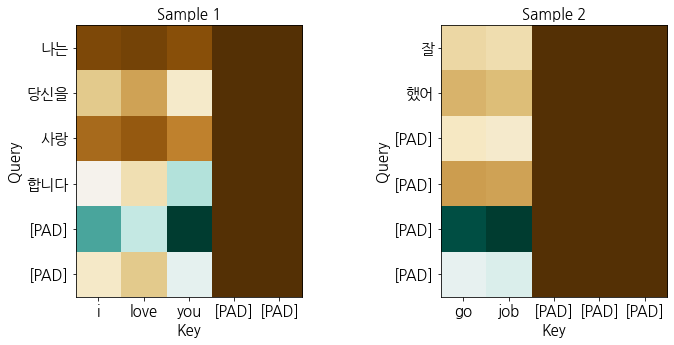

In [ ]:
# padding 결과

### 2. Masked Language Model (MLM)

문장에서 단어 중의 일부를 [Mask] 토큰으로 바꾼 뒤, 가려진 단어를 예측하도록 학습합니다. 이 과정에서 BERT는 문맥을 파악하는 능력을 기르게 됩니다.

ex) 나는 하늘이 예쁘다고 생각한다 -> 나는 하늘이 [Mask] 생각한다.
ex) 나는 하늘이 예쁘다고 생각한다 -> 나는 하늘이 흐리다고 생각한다.
ex) 나는 하늘이 예쁘다고 생각한다 -> 나는 하늘이 예쁘다고 생각한다.

추가적으로 더욱 다양한 표현을 학습할 수 있도록 80%는 [Mask] 토큰으로 바꾸어 학습하지만, 나머지 10%는 token을 random word로 바꾸고, 마지막 10%는 원본 word 그대로를 사용하게 됩니다.

### 3. input representation
- 두 가지 특수 토큰: CLS(Speical Classification token), SEP (Special Separator token)

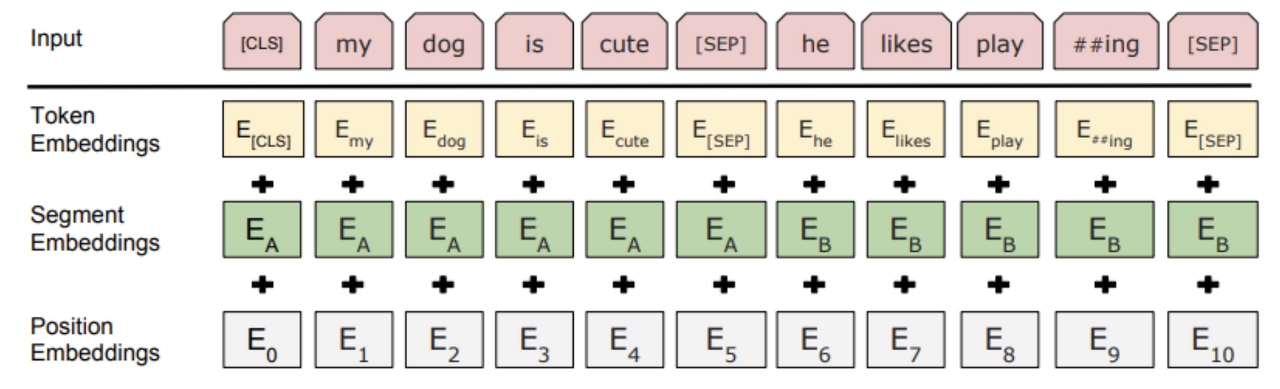